In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


## [ STEP 1 ] : Download & import the house_price dataset. 

train_data_path如果不在kaggle上跑的話，要麻煩老師改一下路徑，其他地方寫好了都不用改。

In [2]:
train_data_path = '/kaggle/input/house-prices-advanced-regression-techniques/train.csv'
# test_data_path = '/kaggle/input/house-prices-advanced-regression-techniques/test.csv'

train_df = pd.read_csv(train_data_path, index_col='Id')
# test_df = pd.read_csv(test_data_path, index_col='Id')

train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


設定資料位置和讀取資料，另外把id設定為index

##  [ STEP 2 ] : Exploratory Data Analysis for the data. 

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

從info給出的資訊，可以看出大部分的資料都是有的，但少部分缺失嚴重，感覺可以直接丟掉，避免影響訓練。

/tmp/ipykernel_20/2018541768.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = train_df.corr()['SalePrice'].sort_values(ascending=False)


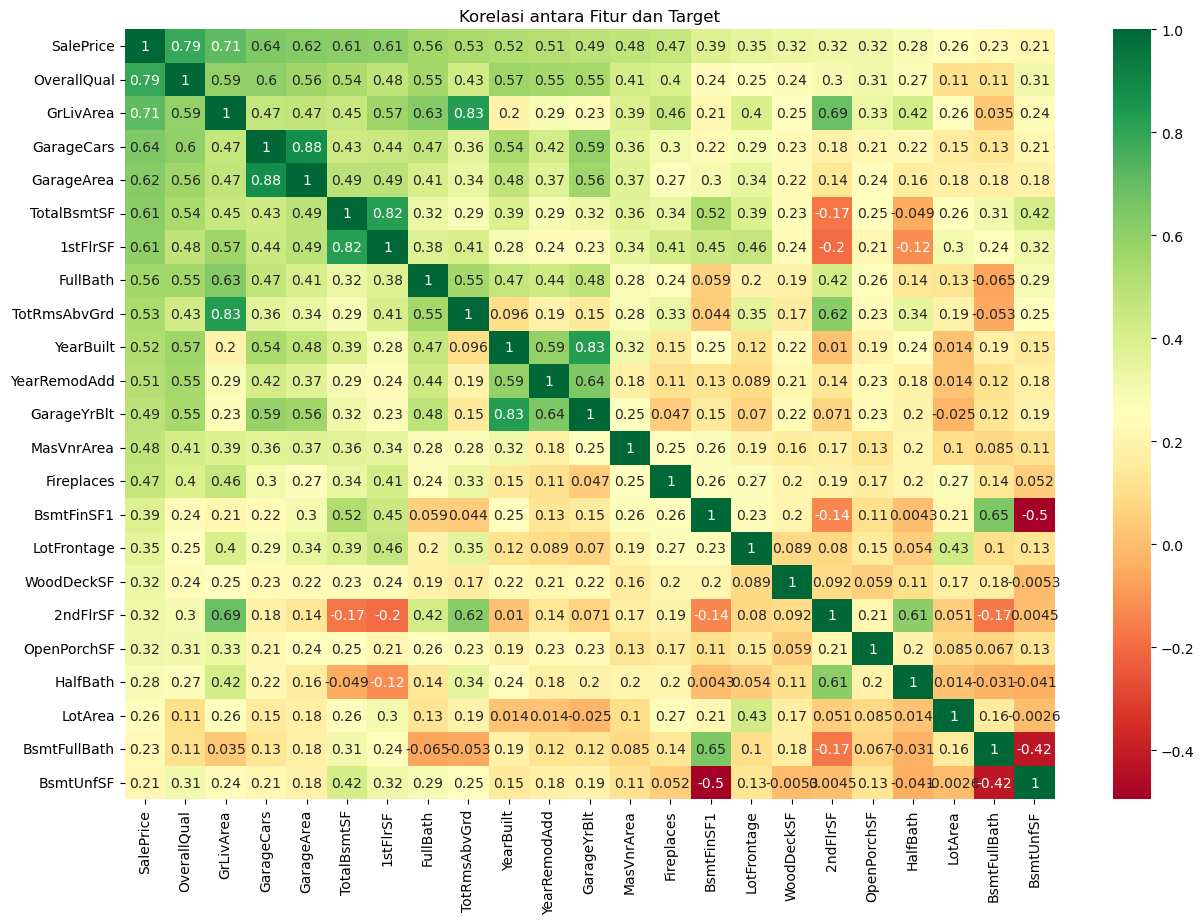

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns

correlation = train_df.corr()['SalePrice'].sort_values(ascending=False)
selected_features = correlation[correlation >= 0.2].index
subset_data = train_df[selected_features]
subset_correlation = subset_data.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(subset_correlation, annot=True, cmap='RdYlGn')
plt.title('Korelasi antara Fitur dan Target')
plt.show()

這裡可以看出SalePrice這個參數和其他參數在皮爾遜積差相關係數中都有0.79到0.21的相關性，大部分feature跟價格都有高度相關，代表這份資料還滿不錯的。

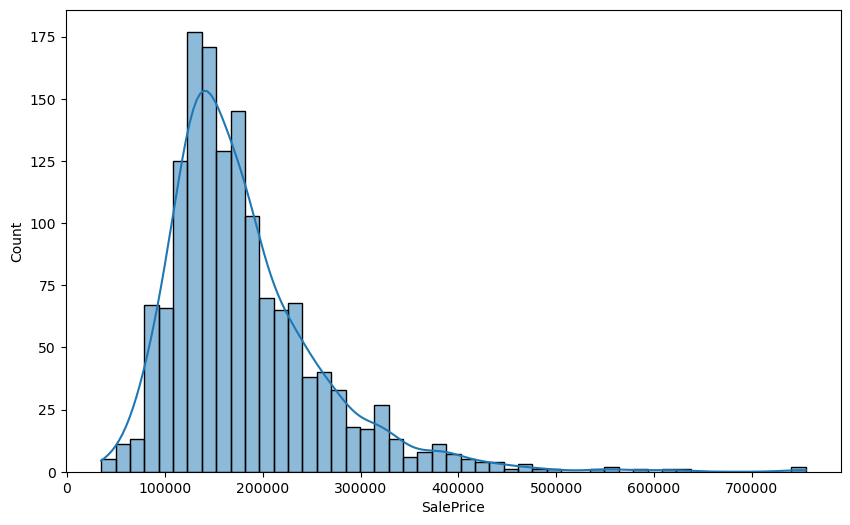

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SalePrice'], kde=True)
plt.xlabel('SalePrice')
plt.ylabel('Count')
plt.show()

房價看起來集中在100000-200000這個價格帶上，不過由於評分標準是RMSE，所以偏離很大的值沒預測好的話也會分數很低，之後lose function要好好選。

## [ STEP 3 ] : Data preprocessing & cleansing for the features. 

我愛特徵工程，所以特徵工程也會愛我。

In [6]:
for i in np.where(train_df.isna().sum() > 0):
    print(train_df.columns[i])
# for i in np.where(test_df.isna().sum() > 0):
#     print(test_df.columns[i])

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')


由於缺失值有點多，全部幹掉是不可能全部幹掉的，這樣train的分數也會讓教授把我幹掉。

In [7]:
# def clean(df):
#     df.drop(['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)
#     return df

# train_df = clean(train_df)
# test_df = clean(test_df)

# train_df.head()

把缺失值超過一半的直接丟掉，這個就算怎麼補效果也不會太好。

補:不丟效果比較好，這幾個感覺是重要參數，總之不能丟，我是小丑。

In [8]:
def fill_nas(df):
    for column in df.columns:
        if column == 'PoolQC':
            df[column] = df[column].fillna('No Pool')
        elif column == 'MiscFeature':
            df[column] = df[column].fillna('No Misc')
        elif column == 'Alley':
            df[column] = df[column].fillna('No Alley')
        elif column == 'Fence':
            df[column] = df[column].fillna('No Fence')
        elif column == 'FireplaceQu':
            df[column] = df[column].fillna('No Fireplace')
        elif column == 'GarageYrBlt':
            df[column] = df[column].fillna(0)
        elif column in ('GarageCond', 'GarageType', 'GarageFinish', 'GarageQual'):
            df[column] = df[column].fillna('No Garage')
        elif column in ('BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1'):
            df[column] = df[column].fillna('No Basement')
        elif column == 'LotFrontage':
            df[column] = df[column].fillna(df[column].mean())
    
    df = df.drop('MasVnrArea', axis=1)
    return df

train_df = fill_nas(train_df)
# test_df = fill_nas(test_df)
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,No Alley,Reg,Lvl,AllPub,Inside,...,0,No Pool,No Fence,No Misc,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,No Alley,Reg,Lvl,AllPub,FR2,...,0,No Pool,No Fence,No Misc,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,No Alley,IR1,Lvl,AllPub,Inside,...,0,No Pool,No Fence,No Misc,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,No Alley,IR1,Lvl,AllPub,Corner,...,0,No Pool,No Fence,No Misc,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,No Alley,IR1,Lvl,AllPub,FR2,...,0,No Pool,No Fence,No Misc,0,12,2008,WD,Normal,250000


NaN獨立搞一個值，反正丟樹類回歸的時候也能跑，但其他回歸塞dataframe的時候會噴錯，後續再用OneHotEncoder把字串轉數值就好。

In [9]:
for i in np.where(train_df.isna().sum() > 0):
    print(train_df.columns[i])
# for i in np.where(test_df.isna().sum() > 0):
#     print(test_df.columns[i])

Index(['MasVnrType', 'Electrical'], dtype='object')


## [ STEP 4 ] : Feature Engineering for obtaining the appropriate features

In [10]:
from sklearn.preprocessing import OneHotEncoder

def OneHotEncoder_df(df):
    cat_columns = [column for column in df.columns if df[column].dtype == 'O']

    df_cat = pd.DataFrame()
    encoder = OneHotEncoder()
    for i in cat_columns:
        cat = pd.DataFrame(data=encoder.fit_transform(df[[i]]).toarray(), columns=encoder.get_feature_names_out())
        if i == 'MSZoning':
            df_cat = cat
        else:
            df_cat = df_cat.join(cat)

    df.drop(cat_columns, axis=1, inplace=True)
    df_cat.reset_index(drop=True, inplace=True)
    df.reset_index(drop=True, inplace=True)

    df = df.join(df_cat)
    return df
    
train_df = OneHotEncoder_df(train_df)
# test_df = OneHotEncoder_df(test_df)
train_df

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,706,0,150,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,20,80.0,9600,6,8,1976,1976,978,0,284,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,60,68.0,11250,7,5,2001,2002,486,0,434,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,70,60.0,9550,7,5,1915,1970,216,0,540,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,60,84.0,14260,8,5,2000,2000,655,0,490,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0,0,953,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1456,20,85.0,13175,6,6,1978,1988,790,163,589,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1457,70,66.0,9042,7,9,1941,2006,275,0,877,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1458,20,68.0,9717,5,6,1950,1996,49,1029,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


function名字懶得想了，反正就是用OneHotEncoder對Object資料(非數值資料)做編碼轉成數值資料。

In [11]:
from sklearn.model_selection import train_test_split

x = train_df.drop('SalePrice', axis = 1)
y = train_df['SalePrice']
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)

## [ STEP 5 ] : Machine learning for building 7 regression models, and then plot and 
是時候展現真正的技術了

* (1) Polynomial Regression (PolynomialFeatures + LinearRegression)
* (2) KNeighborRegressor
* (3) SVR
* (4) DecisionTreeRegressor
* (5) RandomForestRegressor
* (6) XGBRegressor
* (7) MLPRegressor 

In [12]:
# models = []
# preds = []
rmse_list = []
r2_list = []

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

def get_score(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    rmse_list.append(np.sqrt(mse))
    r2_list.append(r2)
    
    print('---------score----------')
    print("R²: %.2f" % r2)
    print("MSE: %.2f" % mse)
    print("RMSE: %.4f" % np.sqrt(mse))
    print("MAPE: %.2f" % (mape * 100) + '%')

#### (1) Polynomial Regression (PolynomialFeatures + LinearRegression)
參考自 https://data36.com/polynomial-regression-python-scikit-learn/

本來看到score想說是不是有寫錯，重複檢查了一下還是覺得沒有，應該只是線性模型擬合程度較差，調了一下參數發現degree=1表現最好，猜想是次方數越高在訓練的時候越難優化，也不一定可以擬合的好。

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=1, include_bias=False)
poly_features = poly.fit_transform(x_train)
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, y_train)
poly_features = poly.transform(x_test)
y_pred = poly_reg_model.predict(poly_features)

# models.append(poly_reg_model)
# preds.append(y_pred)

get_score(y_test, y_pred)

---------score----------
R²: 0.46
MSE: 4154052224.95
RMSE: 64451.9373
MAPE: 12.75%


#### (2) KNeighborRegressor
參考自 https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html 官方文件的範例照著寫。

n_neighbors=4時效果最好，推估是因為高價格房屋鄰近資料點較少，所以n更高的時候高價格房屋偏差極大，n太低的話相鄰資料點數據不足，導致預測效果不佳。

In [15]:
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=4)
neigh.fit(x_train, y_train)
y_pred = neigh.predict(x_test)

# models.append(neigh)
# preds.append(y_pred)

get_score(y_test, y_pred)

---------score----------
R²: 0.73
MSE: 2099374671.92
RMSE: 45818.9336
MAPE: 16.89%


#### (3) SVR

同樣也是參考自https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html 官方文檔。

本來有參照官方文件使用 StandardScaler() 做前處理，但感覺效果不好後續還是先拔掉了，調了一下參數覺得都有點糟糕，估計是因為lose function沒有貼合RMSE和SVR的優化很難做。

本來預測的值計算R2 score甚至是負數，不過後期換kernel='linear'之後，R2 score從負值變成正值，感覺是目標函數的問題。

In [16]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

regr = SVR(C=1, epsilon=0.1, kernel='linear')
regr.fit(x_train, y_train)
y_pred = regr.predict(x_test)

# models.append(regr)
# preds.append(y_pred)

get_score(y_test, y_pred)

---------score----------
R²: 0.78
MSE: 1718947545.23
RMSE: 41460.1923
MAPE: 13.31%


#### (4) DecisionTreeRegressor

參考自https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

本來想說只有單顆樹效果會不太好，沒想到成效超乎預期，感覺是樹類結構天生適合對大量雜亂的數據做優化，這裡沒什麼要調參的部分，看了一下文檔，默認就是算出來的最佳分割，根據文檔說法，這邊感覺調參反而會降低模型成效。

In [17]:
from sklearn.tree import DecisionTreeRegressor

regr = DecisionTreeRegressor()
regr.fit(x_train, y_train)
y_pred = regr.predict(x_test)

# models.append(regr)
# preds.append(y_pred)

get_score(y_test, y_pred)

---------score----------
R²: 0.72
MSE: 2148159488.35
RMSE: 46348.2415
MAPE: 16.23%


#### (5) RandomForestRegressor

參考自 https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

為了確定每次的輸出都一樣，先設定random_state=42，由於RandomForestRegressor可以看成是
n_estimators個DecisionTreeRegressor，所以效果更好並不意外，
n_estimators高一點，效果就好一點，但差異不大。

In [18]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(random_state=42, 
n_estimators=500)

regr.fit(x_train, y_train)
y_pred = regr.predict(x_test)

# models.append(regr)
# preds.append(y_pred)

get_score(y_test, y_pred)

---------score----------
R²: 0.89
MSE: 835190384.07
RMSE: 28899.6606
MAPE: 10.64%


#### (6) XGBRegressor

參考自 https://xgboost.readthedocs.io/en/stable/python/python_api.html

訓練效果比RandomForestRegressor略差，但好好調參的話成效應該會更好一點，畢竟XGBRegressor可以調的東西更多，但他原先的參數就滿好的了，試了一下發現還不如用原本的參數。

In [19]:
from xgboost import XGBRegressor

xgboost = XGBRegressor(n_estimators=500)

xgboost.fit(x_train, y_train)
y_pred = xgboost.predict(x_test)

# models.append(xgboost)
# preds.append(y_pred)

get_score(y_test, y_pred)

---------score----------
R²: 0.89
MSE: 876343014.15
RMSE: 29603.0913
MAPE: 10.21%


#### (7) MLPRegressor

參考自 https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

其實就是sklearn給出的MLP快速構建版，測試發現兩層以上效果都差不多，畢竟MLP對於過多feature的資料，需要相較於tree多更多的資料量，所以分數低於tree類模型並不意外。

In [20]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(hidden_layer_sizes=(32,16), activation="relu",
                 solver='adam', random_state=42)
regr.fit(x_train, y_train)
y_pred = regr.predict(x_test)

# models.append(regr)
# preds.append(y_pred)

get_score(y_test, y_pred)

---------score----------
R²: 0.72
MSE: 2162377262.92
RMSE: 46501.3684
MAPE: 16.86%


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## [ STEP 6 ] : Discussion and Conclusion. 

#### plot and compare them with both R2 scores & RMSE values. 

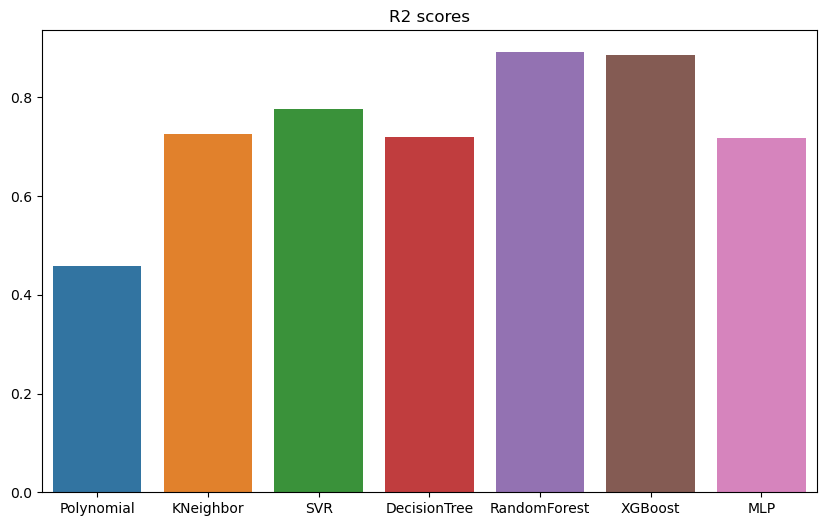

In [21]:
models_name = ['Polynomial', 'KNeighbor', 
              'SVR', 'DecisionTree', 
              'RandomForest',
              'XGBoost', 'MLP']


plt.figure(figsize=(10, 6))
sns.barplot(x=models_name, y=r2_list)
plt.title('R2 scores')
plt.show()

可以從R2繪製出來的數據看到，SVR的效果最差，R2 score的值為負代表的含意是拿平均值去猜都比用模型來預測來的好，調參完之後R2 score都是正的應該沒有太大問題，另外樹類演算法在這種feature量大的數值資料上表現亮點。

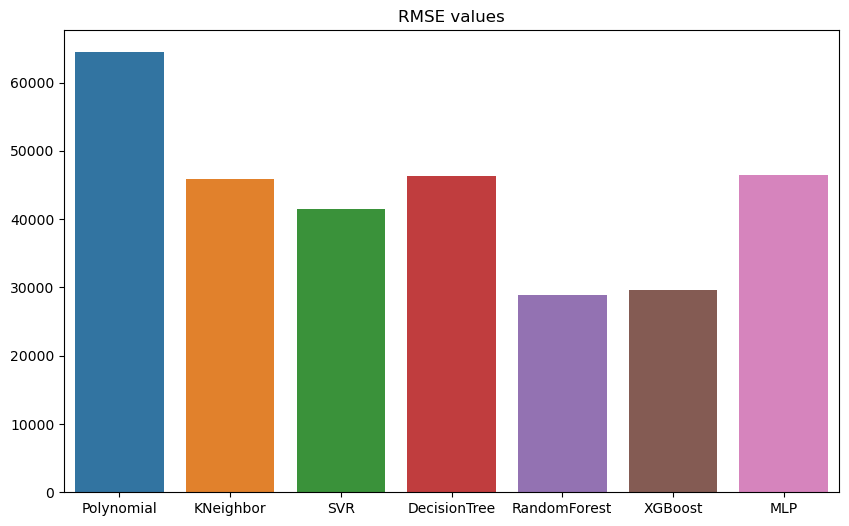

In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(x=models_name, y=rmse_list)
plt.title('RMSE values')
plt.show()

RMSE values 是均方根誤差，對於離群值很敏感，所以只要一個數值預測差異過大就會很影響模型效能，在這部份上樹類模型表現優異，另外讓人驚豔的是KNeighborRegressor，在資料夠大的情況下，其實預測效果會高於很多目標函數和數據對不上的模型。

### 各模型表現探討

#### (1) Polynomial Regression (PolynomialFeatures + LinearRegression)¶

調了一下參數發現degree=1表現最好，猜想是次方數越高在訓練的時候越難優化，也不一定可以擬合的好。

#### (2) KNeighborRegressor

n_neighbors=4時效果最好，推估是因為高價格房屋鄰近資料點較少，所以n更高的時候高價格房屋偏差極大，n太低的話相鄰資料點數據不足，導致預測效果不佳。

#### (3) SVR

本來有參照官方文件使用 StandardScaler() 做前處理，但感覺效果不好後續還是先拔掉了，調了一下參數覺得都有點糟糕，估計是因為lose function沒有貼合RMSE和SVR的優化很難做。

本來預測的值計算R2 score甚至是負數，不過後期換kernel='linear'之後，R2 score從負值變成正值，感覺是目標函數的問題。

#### (4) DecisionTreeRegressor¶

本來想說只有單顆樹效果會不太好，沒想到成效超乎預期，感覺是樹類結構天生適合對大量雜亂的數據做優化，這裡沒什麼要調參的部分，看了一下文檔，默認就是算出來的最佳分割，根據文檔說法，這邊感覺調參反而會降低模型成效。

#### (5) RandomForestRegressor

為了確定每次的輸出都一樣，先設定random_state=42，由於RandomForestRegressor可以看成是 n_estimators個DecisionTreeRegressor，所以效果更好並不意外， n_estimators高一點，效果就好一點，但差異不大。

#### (6) XGBRegressor

訓練效果比RandomForestRegressor略差，但好好調參的話成效應該會更好一點，畢竟XGBRegressor可以調的東西更多，但他原先的參數就滿好的了，試了一下發現還不如用原本的參數。

#### (7) MLPRegressor

其實就是sklearn給出的MLP快速構建版，測試發現兩層以上效果都差不多，畢竟MLP對於過多feature的資料，需要相較於tree多更多的資料量，所以分數低於tree類模型並不意外。